# Data Processiong

## Loading Data

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt



In [10]:
data = pd.read_csv('data/raw_survey_data_2022.csv',header=None)

In [11]:
# with sub-questions as header
df = pd.read_csv('data/raw_survey_data_2022.csv',header=1)

## Data cleaning

In [4]:
# Check if there are invalid responses 
# 1. the response column is correct (most essential:If you have read the survey up to this point, please select the number four (4). By selecting number 4, you'll be entered to win one of the prizes.)
# 2. response time more than 200s

In [12]:
## Finding the response question and their column indices
data.loc[0,data.iloc[0,:].str.contains('If you have read the survey up to this point')==True].index

Int64Index([176, 306], dtype='int64')

In [13]:
## 1 response column is correct
df_1=df[(df.iloc[:,176]=='2')&(df.iloc[:,306]=='4')]

In [14]:
## 2 response time more than 200s
def response_time(df,minimum=200):
    data1=df.iloc[:,1] #DataFrame with start time
    data2=df.iloc[:,2] #DataFrame with end time
    data3=df.iloc[:,3:] #DataFrame with data

    data3["time"]=data2.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))-data1.apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))
    #(data1.iloc[:,1].values.astype('datetime64[D]')-data1.iloc[:,0].values.astype('datetime64[D]'))

                                                                                                    
    index_time= data3["time"].apply(lambda x: x/np.timedelta64(1, 's'))
    data3['clean']=(index_time>200)
    cleaned_data=data3.loc[data3.clean==True].iloc[:,:-2]

    return cleaned_data
cleaned_data=response_time(df_1,200)

cleaned_data.shape

(1271, 348)

In [15]:
## change some answer to numerical
def numeric_scale(cleaned_data):
    for i in range(cleaned_data.shape[0]):
        for j in range(cleaned_data.shape[1]):
            if cleaned_data.iloc[i,j]=='Strongly agree':
                cleaned_data.iloc[i,j]=5
            if cleaned_data.iloc[i,j]=='Agree':
                cleaned_data.iloc[i,j]=4
            if cleaned_data.iloc[i,j]in['Neither agree or disagree','Neither agree nor disagree','Neither disagree nor agree']:
                cleaned_data.iloc[i,j]=3
            if cleaned_data.iloc[i,j]=='Disagree':
                cleaned_data.iloc[i,j]=2
            if cleaned_data.iloc[i,j]=='Strongly disagree':
                cleaned_data.iloc[i,j]=1
    return cleaned_data


cleaned_data=numeric_scale(cleaned_data)

##  Basic Statistics

In [9]:
##calculating the counts of each question

In [16]:
counts=[]
for i in range(len(cleaned_data.columns)):
    counts.append(dict(cleaned_data.iloc[:,i].value_counts()))


## Creating Question Table

In [17]:
# create the table of the first 2 rows to see the questions and the columns they locate
Q=data.iloc[:2,3:].T
Q.columns=['Question','Sub_Question']
#Q['location']=[ lambda x: x.index*(x.Question.isna()==False)]
Q=Q.reset_index(drop=True)
Q['location']=np.where(Q.Question.isna()==False, Q.Question.index, "False")
Q['counts']=counts

In [18]:
# Main questions
qq=Q[Q['location']!='False']
qq=qq.reset_index(drop=True)

In [19]:
Q.to_csv("output/Questions-22.csv", index=True)

In [20]:
pd.options.display.max_colwidth=120

In [15]:
Q.Question

0                                    I am satisfied with my overall experience at Columbia.
1      I am satisfied with the following with respect to my overall experience at Columbia.
2                                                                                       NaN
3                                                                                       NaN
4                                                                                       NaN
                                               ...                                         
343                                                                                     NaN
344                                                               What is your current age?
345                                                         Is English your first language?
346              Was English the medium of instruction in your primary or secondary school?
347           Let us know about other important matters that are not covered by 

## Find dataset for queryed text



In [21]:
##Find dataset for queryed text

def query_data(Q,qq,cleaned_data,query,indx):
    que=Q[Q['Question'].str.contains(query)==True]
    val=que.values
    ind=que.index.values
    print(Q.loc[ind[indx-1],'Question'])
    start=ind[indx-1]
    end=int(qq.iloc[qq[qq.location==str(ind[indx-1])].index+1]['location'])
    df_return=cleaned_data.iloc[:,start:end]
    return df_return



# Initial Analysis

## 1 How Satisfied are the SEAS students

In [22]:

query="satisfied"
indx=1  # the index of quetion you want to query among all questions that contains your query text, 
        # for example: I want to know the second question involves "satisfied", the indx is 2


df_satisfied = query_data(Q,qq,cleaned_data,query,indx=1)

I am satisfied with my overall experience at Columbia.


In [118]:
import matplotlib as mpl



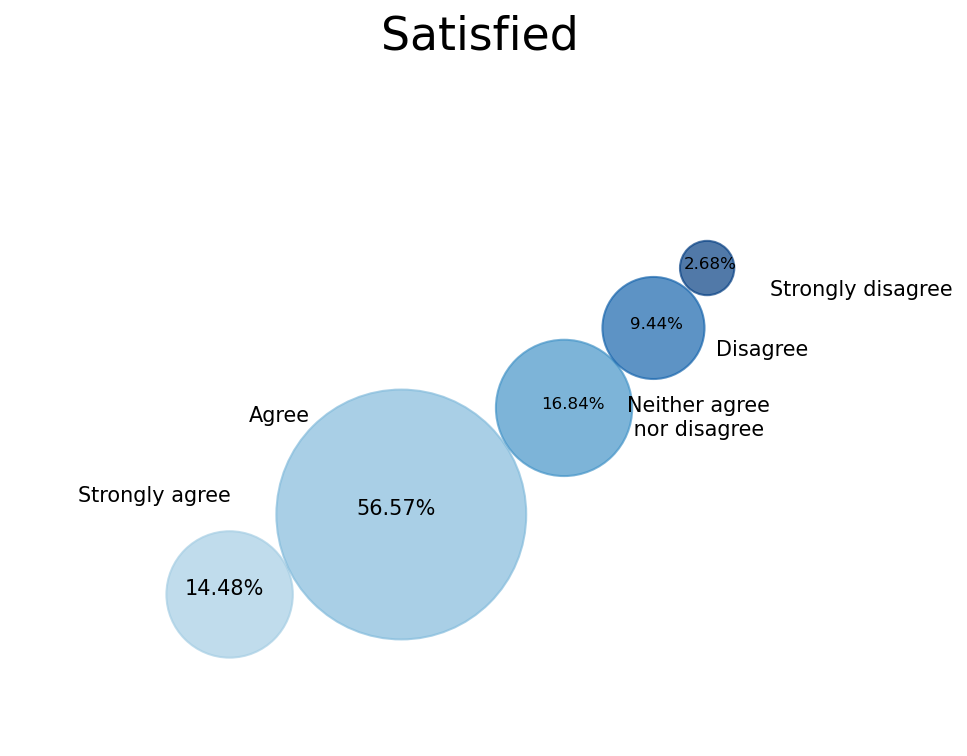

In [136]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']
a=(df_satisfied.Response.value_counts()).sort_index(ascending=False)

fig,ax0=plt.subplots(figsize=(8,6),dpi=150)

# use the scatterplot function to build the bubble map
#sns.scatterplot(x=[1,2,2.5,3,3.5], y=[0.9,1.5,1.84,1.9,2.5], size=a, legend=False, sizes=(200,20000),ax=ax0)
ax0.set_xlim([-0.2, 5.0])
ax0.set_ylim([-0.10, 5.0])
x=[1,1.96,2.87,3.37,3.67]
y=[1,1.6,2.4,3,3.45]
colors=[2.8,2.5,1.9,1.3,0.8]
sc=plt.scatter(x, y,s=a*20, c=colors, cmap=cmap,  alpha=0.7)
#plt.colorbar(sc)
for i in range(2):
    ax0.annotate(indd[i],(x[i]-0.85,y[i]+0.7))
    ax0.annotate(str(round(a[5-i]/a.sum()*100,2))+"%",(x[i]-0.25,y[i]-0))
for i in range(2,5):
    ax0.annotate(indd[i],(x[i]+0.35,y[i]-0.2))
    ax0.annotate(str(round(a[5-i]/a.sum()*100,2))+"%",(x[i]-0.13,y[i]-0),fontsize=8)
ax0.set_title("Satisfied",fontsize=22)



plt.axis('off')

# show the graph
plt.show()


## 2 Importance v.s. Satisfaction

In [24]:
df_important=query_data(Q,qq,cleaned_data,"important",indx=1)

The following are important with respect to my overall experience at Columbia.


In [25]:
df_satisfied2 = query_data(Q,qq,cleaned_data,"satisfied",indx=2)

I am satisfied with the following with respect to my overall experience at Columbia.


In [26]:
a=pd.DataFrame(df_satisfied2.mean()).T
b=pd.DataFrame(df_important.mean()).T
b.columns=a.columns
c2022=pd.concat([a,b],ignore_index=True)
c2022['Year']=2022

In [27]:
data_2019 = pd.read_csv('data/Copy of de-identified Graduate Student Quality of Life Survey - Spring 2019.xlsx - Graduate Student Quality of Lif.csv',header=1)

In [28]:
# use the same way to clean 2019 data
print(data_2019.shape)
cleaned_data_2019=response_time(data_2019,200)
cleaned_data_2019.shape

(1033, 345)


(997, 342)

In [29]:

d2019=numeric_scale(cleaned_data_2019)

In [30]:

df_satisfied2019=query_data(Q,qq,d2019,"satisfied",indx=2)
df_important2019=query_data(Q,qq,d2019,"important",indx=1)

I am satisfied with the following with respect to my overall experience at Columbia.
The following are important with respect to my overall experience at Columbia.


In [31]:
aa=pd.DataFrame(df_satisfied2019.mean()).T
bb=pd.DataFrame(df_important2019.mean()).T
bb.columns=aa.columns

c2019=pd.concat([aa,bb],ignore_index=True)
c2019['Year']=2019


In [32]:
c2019.columns=c2022.columns
cc=pd.concat([c2019,c2022],ignore_index=True)
cc

,Academics,Mental health,Physical health,Professional development,Social life,Career Placement Team,Housing,Intercampus Shuttle/Via Service,Library services,Funding opportunities,Student life and academic advising,Technology services and support,Year
0,3.993982,3.579739,3.669007,3.839519,3.641926,3.648947,3.236710,3.502508,4.125376,3.184554,3.744233,3.898696,2019
1,4.538616,4.169509,4.183551,4.324975,3.998997,4.299900,3.863591,3.304915,4.131394,3.953862,4.248746,4.056169,2019
2,3.883556,3.430370,3.530291,3.675846,3.536585,3.260425,3.235248,3.653029,4.084186,3.024390,3.484658,3.713611,2022
3,4.597168,4.289536,4.210071,4.332809,4.143981,4.274587,3.901652,3.804878,4.047994,4.009441,4.313139,3.985051,2022


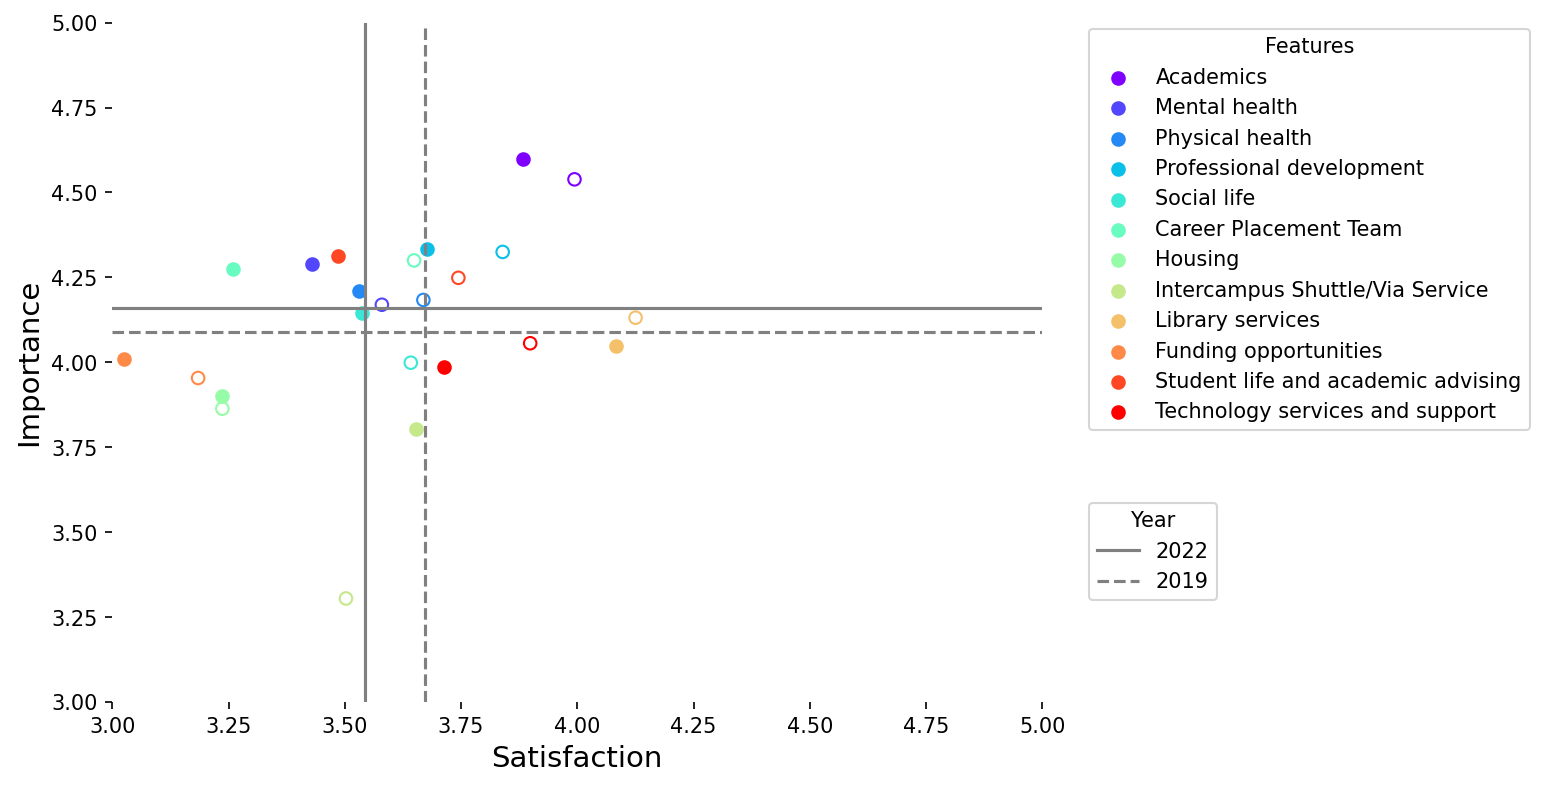

In [137]:
#plt.scatter(c.iloc[0,:],c.iloc[1,:])
import matplotlib.cm as cm


fig,ax=plt.subplots(figsize=(8,6),dpi=150)


colors = cm.rainbow(np.linspace(0, 1, (12)))

for i in range(12):
    ax.scatter(c2022.iloc[0,i], c2022.iloc[1,i],label=c2022.columns[i],c=colors[i].reshape(1,-1))

for i in range(12):
    ax.scatter(c2019.iloc[0,i], c2019.iloc[1,i],marker='o',facecolors='none',edgecolors=colors[i].reshape(1,-1))

line1=ax.axhline(y=c2022.iloc[1,:-1].mean(),c='grey')
ax.axvline(x=c2022.iloc[0,:-1].mean(),c='grey' )

line2=ax.axhline(y=c2019.iloc[1,:-1].mean(),c='grey',ls='--')
ax.axvline(x=c2019.iloc[0,:-1].mean(),c='grey' ,ls='--')


ax.set_xlim([3.0, 5.0])
ax.set_ylim([3.0, 5.0])


#ax.set_title("Importance vs Satisfaction for all features",fontsize=22)


#second_legend=plt.legend(c.columns,bbox_to_anchor=(1, 2.5))
#second_legend=plt.legend(c.columns,loc="upper left")

leg = plt.legend(loc=(1.05,0.4), title="Features")
ax.add_artist(leg)

#first_legend=plt.legend([line1,line2],['2022','2019'],bbox_to_anchor=(1, 1.05))
plt.legend(handles=[line1,line2], labels=['2022','2019'],loc=(1.05,0.15), title="Year")


ax.set_xlabel("Satisfaction",fontsize=14)
ax.set_ylabel("Importance",fontsize=14)

#for i,txt in enumerate(np.arange(12)):
 #   print(i,txt)
    #ax.annotate(txt,(c.columns[i]))
#for i in range(6,10):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i], c2022.iloc[1,i]))
#for i in range(0,2):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]+0.02, c2022.iloc[1,i]-0.035))
#for i in range(3,5):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]+0.02, c2022.iloc[1,i]-0.035))
#for i in range(2,3):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.38, c2022.iloc[1,i]-0.035))
#for i in range(5,6):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.28, c2022.iloc[1,i]-0.05))
#for i in range(10,11):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i]-0.48, c2022.iloc[1,i]+0.1))
#for i in range(11,12):
#    ax.annotate(c2022.columns[i],(c2022.iloc[0,i], c2022.iloc[1,i]-0.05))
    
ax.axhline(y=c2022.iloc[1,:].mean())
ax.axvline(x=c2022.iloc[0,:].mean(),c='black' )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



plt.show()





## 3 Satisfaction on other basis

In [82]:
degree=query_data(Q,qq,cleaned_data,'Current Academic Program',indx=1)
department=query_data(Q,qq,cleaned_data,'current academic department',indx=1)
gender=query_data(Q,qq,cleaned_data,'gender',indx=3)
LGBTQ=query_data(Q,qq,cleaned_data,'LGBTQ',indx=1)
ethnic=query_data(Q,qq,cleaned_data,'ethnic',indx=1)
country=query_data(Q,qq,cleaned_data,'Country',indx=1)
age=query_data(Q,qq,cleaned_data,'age',indx=3)

Current Academic Program
What is your current academic department or institute?
Please indicate the gender(s) with which you identify (check all that apply):
Do you identify yourself as part of the LGBTQ community?
Please identify your ethnic background.
Country of Origin
What is your current age?


## Satisfation by Gender

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


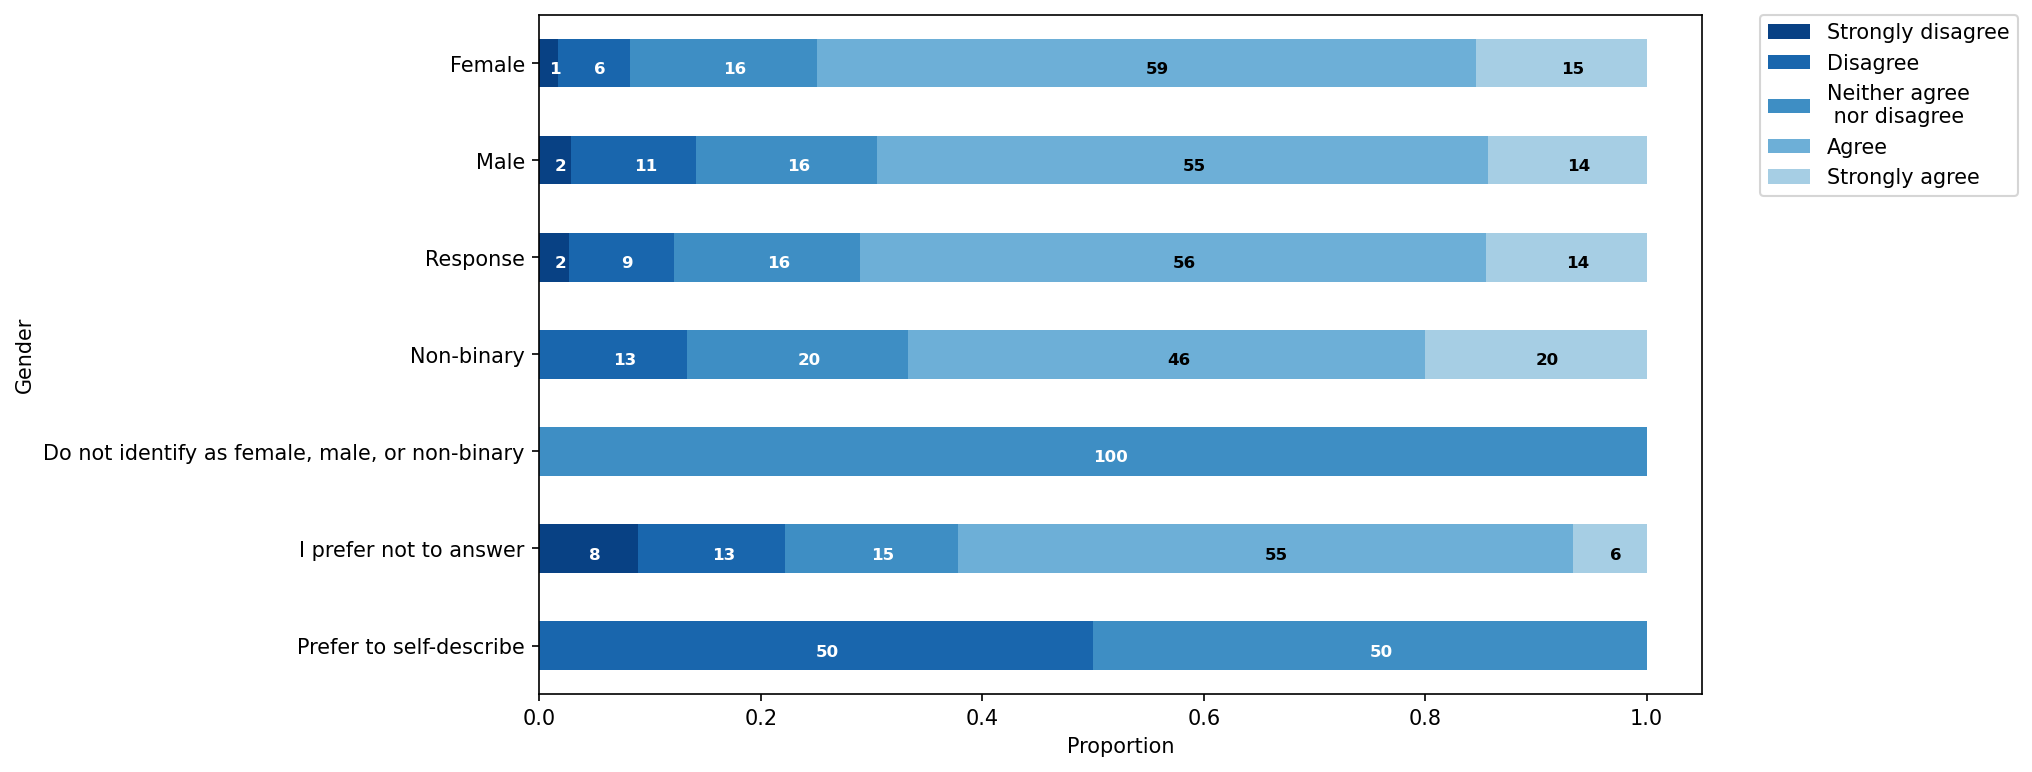

In [171]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


df_satisfied_gender=df_satisfied.copy()
df_satisfied_gender=df_satisfied_gender.join(gender)

gender_c=['Female','Male','Response','Non-binary','Do not identify as female, male, or non-binary','I prefer not to answer','Prefer to self-describe']
b=pd.DataFrame(columns=gender_c) 
for i in gender_c:
    data_used=df_satisfied_gender.loc[df_satisfied_gender[i].isna()!=True,'Response']
    b[i]=(pd.DataFrame(data_used.value_counts()).fillna(0)/pd.DataFrame(data_used).count(axis=0)*100)
    #print(pd.DataFrame(data_used).count(axis=0))  
 #b.append(a)

b=b[b.columns[::-1]]
b_prob=b.apply(lambda x: x / x.sum(), axis=0)
aaa=b.sort_index().T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Gender")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Gender",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1

plt.show()

## Satisfaction By Degree

In [350]:
df_satisfied_degree=df_satisfied.copy()
df_satisfied_degree['degree']=degree
df_satisfied_degree['num']=1
dff=df_satisfied_degree.groupby(['degree','Response']).count().unstack('degree')
df_degree=dff['num']#/dfff.sum(axis=0)
#dff.to_csv("output/df_satisfied_degree.csv")
#df_degree=dff['num'].drop(columns='Professional Degree')
df_degree=df_degree.fillna(0)
#df_satisfied_degrea['Response']=df_satisfied_degree.Response.astype(int)
inner=df_satisfied_degree.groupby(['degree','Response']).sum()
outer = df_satisfied_degree.groupby('degree').sum()
outer

,num
degree,
Doctor of Philosophy (Ph.D.),208
M.S. leading to Ph.D.,74
Master of Science (M.S.),988
Professional Degree,1


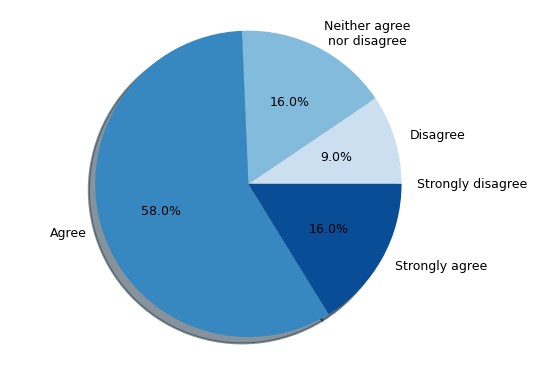

In [354]:
# Create a pieplot

fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
cmap = mpl.cm.Blues(np.linspace(0,2,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

explode = (0, 0, 0, 0,0) 
_, _, autotexts =ax.pie(df_degree['M.S. leading to Ph.D.'], explode=explode, labels=indd[::-1], autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmap,
        shadow=True,textprops={'fontsize': 6})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


posx and posy should be finite values
posx and posy should be finite values


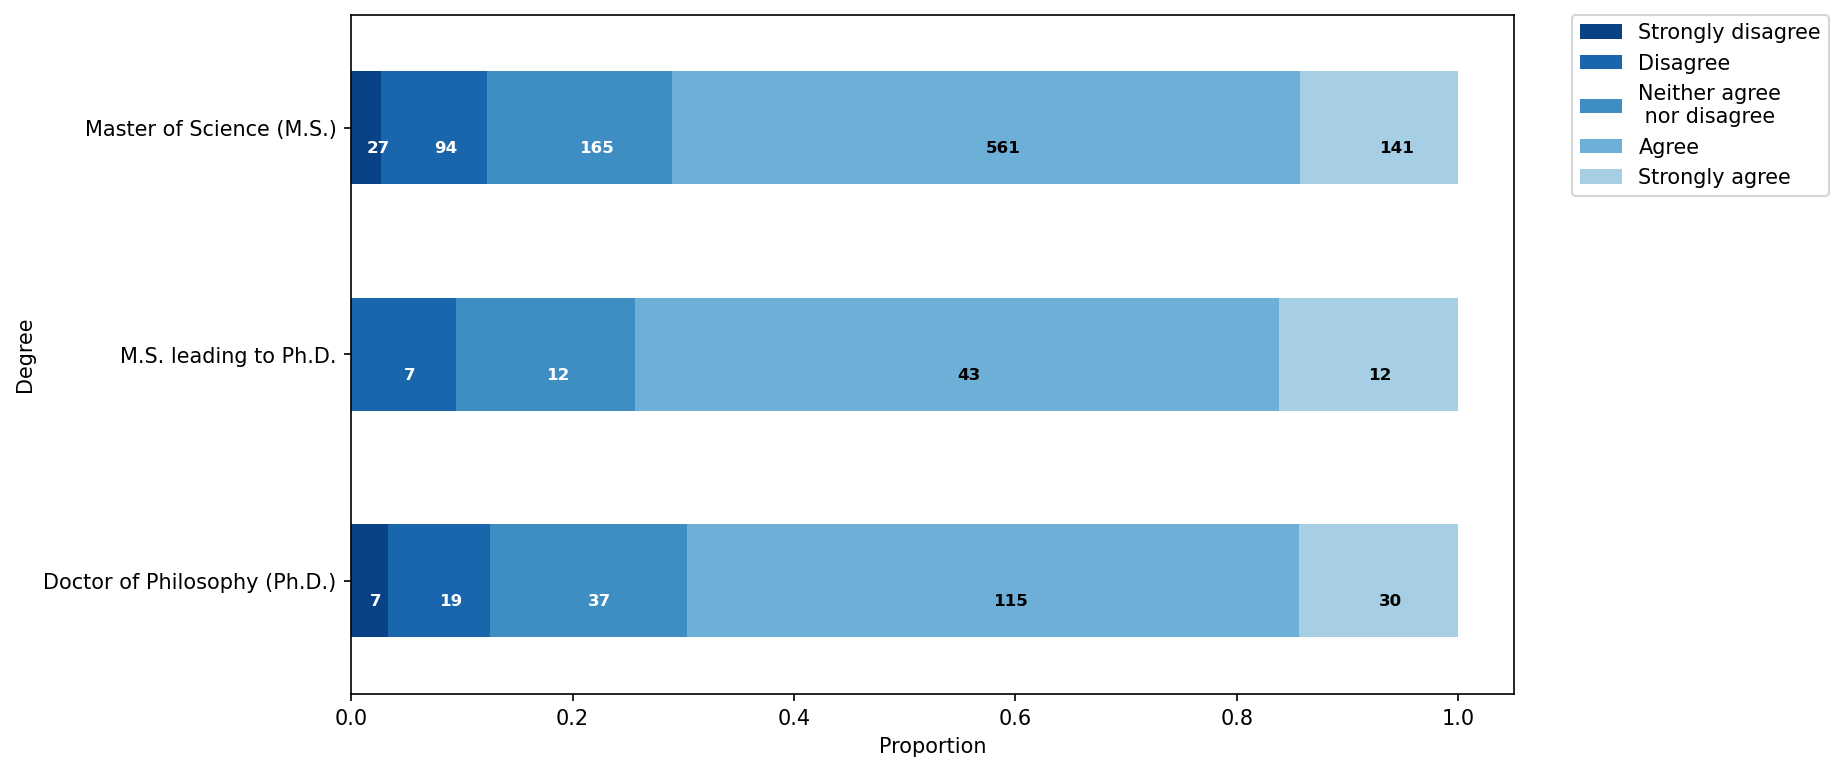

In [142]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


b_prob=df_degree.apply(lambda x: x / x.sum(), axis=0)
aaa=df_degree.T
bbb=b_prob.sort_index().T


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Degree")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1

plt.show()

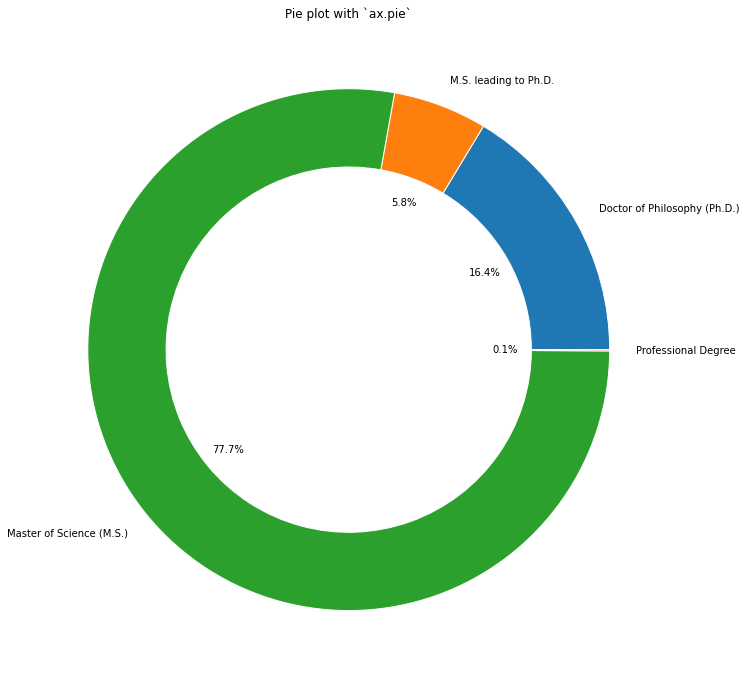

In [335]:
fig, ax = plt.subplots(figsize=(24,12))
size = 0.3

ax.pie(outer.values.flatten(), radius=1,
       labels=outer.index,
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

#ax.pie(inner.values.flatten(), radius=1-size, 
#       labels = inner_labels,
#       wedgeprops=dict(width=size, edgecolor='w'),colors=cmap)

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

## Satisfaction by Department

Text(0.5, 0, 'number of responses')

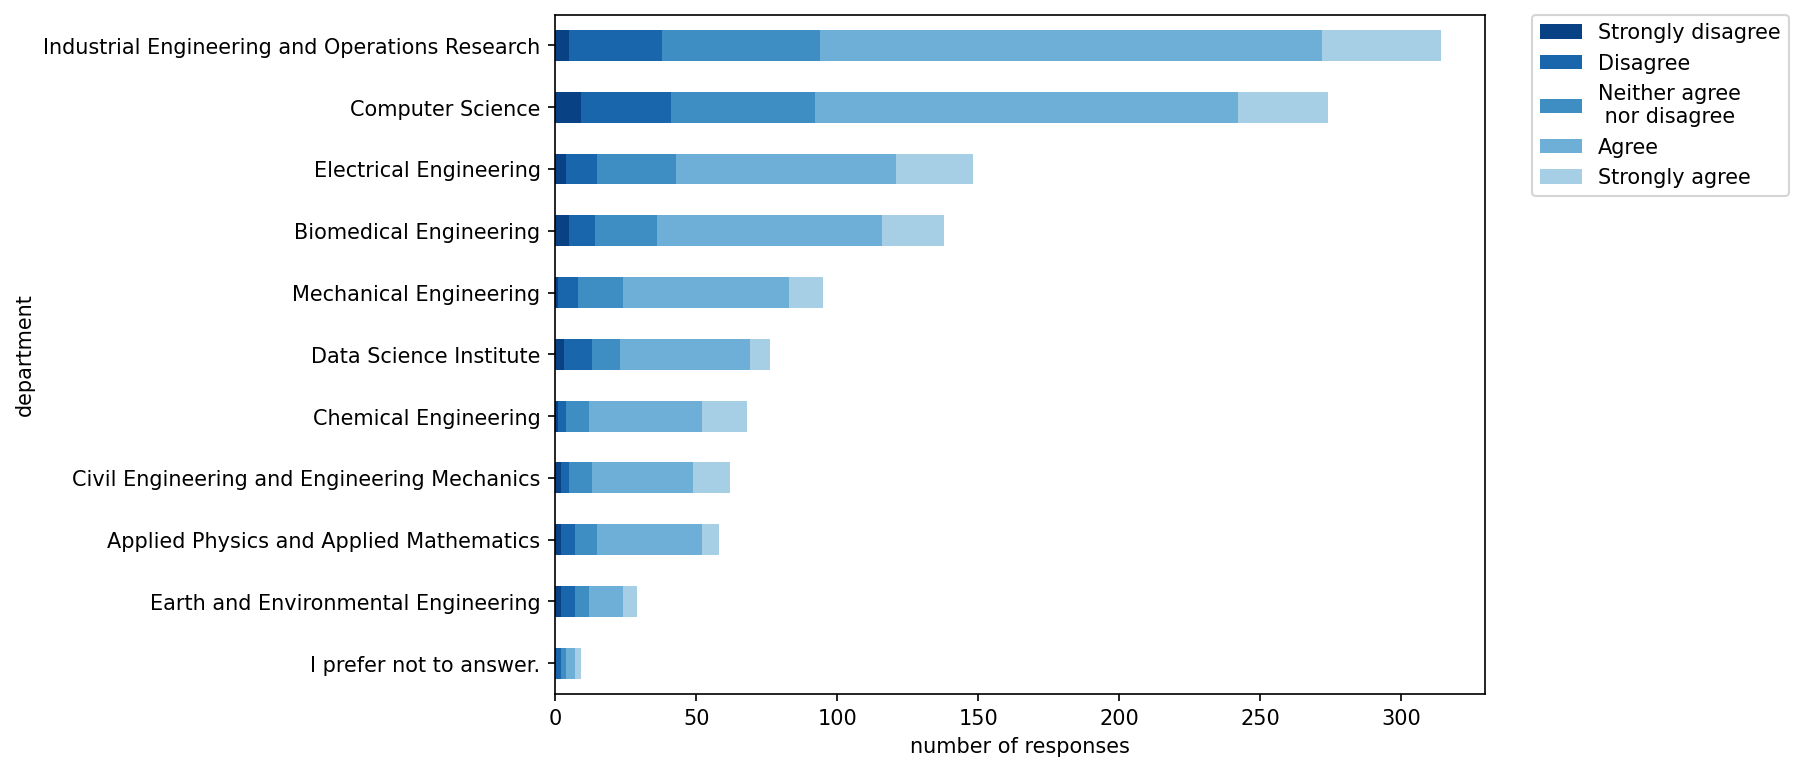

In [172]:
#cm = plt.cm.get_cmap('RdYlBu')
cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


df_satisfied_department=df_satisfied.copy()
df_satisfied_department['department']=department
df_satisfied_department['num']=1
dff=df_satisfied_department.groupby(['department','Response']).count().unstack('department')
#/dfff.sum(axis=0)
indd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree']


#dff.to_csv("output/df_satisfied_degree.csv")
df_department=dff['num']
df_department.fillna(0)
df_d=df_department[(df_department.sum(axis=0)).sort_values().index]


fig,ax=plt.subplots(figsize=(8,6),dpi=150)
df_d.T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(8,6),ax=ax)
plt.legend(indd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
ax.set_xlabel("number of responses")


## Satisfaction 

In [334]:
PDL_sat=query_data(Q,qq,cleaned_data,"satisfied",indx=3)
PDL_sat.value_counts()

I am satisfied with the PDL Core Modules.


Response.6
4             512
5             213
3             137
2              69
1              42
dtype: int64

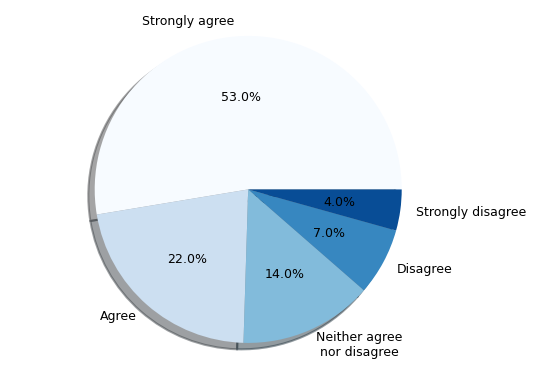

In [363]:
fig,ax=plt.subplots(figsize=(4,3),dpi=150)
#plt.pie(np.array(df_degree.iloc[:,0]),color=cmap)
cmap = mpl.cm.Blues(np.linspace(0,2,10))
#cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

explode = (0, 0, 0, 0,0) 
_, _, autotexts =ax.pie(PDL_sat.value_counts(), explode=explode, labels=indd, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '',colors=cmap,
        shadow=True,textprops={'fontsize': 6})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



The following are important with respect to my overall satisfaction with SEAS classes and academics.


<AxesSubplot:>

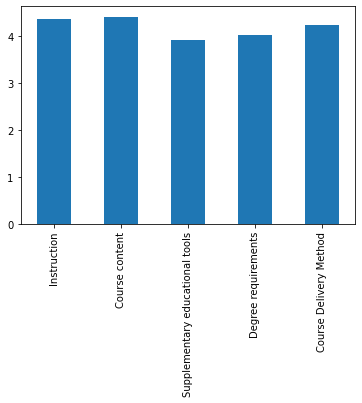

In [348]:
query_data(Q,qq,cleaned_data,"academics",indx=1).mean(axis=0).plot(kind="bar")

In [349]:
query_data(Q,qq,cleaned_data,"academics",indx=2).columns

Please answer the following with respect to SEAS classes and academics.


Index(['The overall teaching quality of the lecturer was satisfactory:',
       'Theory and practical application were well-balanced:',
       'The course load was manageable:',
       'The availability of courses to satisfy degree requirements was satisfactory:',
       'There was a wide selection of  elective courses available:',
       'My degree requirements allowed me to take enough elective courses to tailor my education:',
       'The online course descriptions were available and accurate:',
       'The department websites are informative and easy to use:',
       'The degree requirements were clearly communicated at the start of the program:',
       'My coursework provided adequate preparation for my desired career choice:',
       'There were frequent academic and professional seminars of high quality:',
       'The Teaching Assistants (TA) were well equipped to help students with the course content:',
       'The Teaching Assistants (TA) conducted themselves responsibly:',
 

In [ ]:
(df3_2_library.mean()).sort_values().plot(kind="barh")
plt.ylabel("Resources")
plt.xlabel("importance")
plt.title("Significance of resources provided by CCE",fontsize=20)


for n,x in enumerate([*(df3_2_library.mean()).sort_values().index.values]):
        plt.text(x=0.5,
                 y=n - 0.11,
                 s=f'{df3_2_library.mean().loc[x] :0.5f}', 
                 color="white",
                 fontsize=12,
                 fontweight="bold")
        
(df3_2_library.mean()).sort_values(ascending=False)

In [322]:
resources_sat.mean(axis=0)
resources_sat_count=resources_sat.apply(pd.value_counts,axis=0)



In [324]:
df_satisfied_department=df_satisfied.copy()
df_satisfied_department['department']=department
df_satisfied_department['num']=1
dff=df_satisfied_department.groupby(['department','Response']).count().unstack('department')
#/dfff.sum(axis=0)
inddd=['Strongly agree','Agree','Neither agree \n nor disagree','Disagree','Strongly disagree','Unaware of this resource']



In [306]:
resources_sat=query_data(Q,qq,cleaned_data,"satisfied",indx=6)
resources_sat.replace('Unaware of this resource',0,inplace=True)

I am satisfied with the following resources with respect to guidance in my degree program.


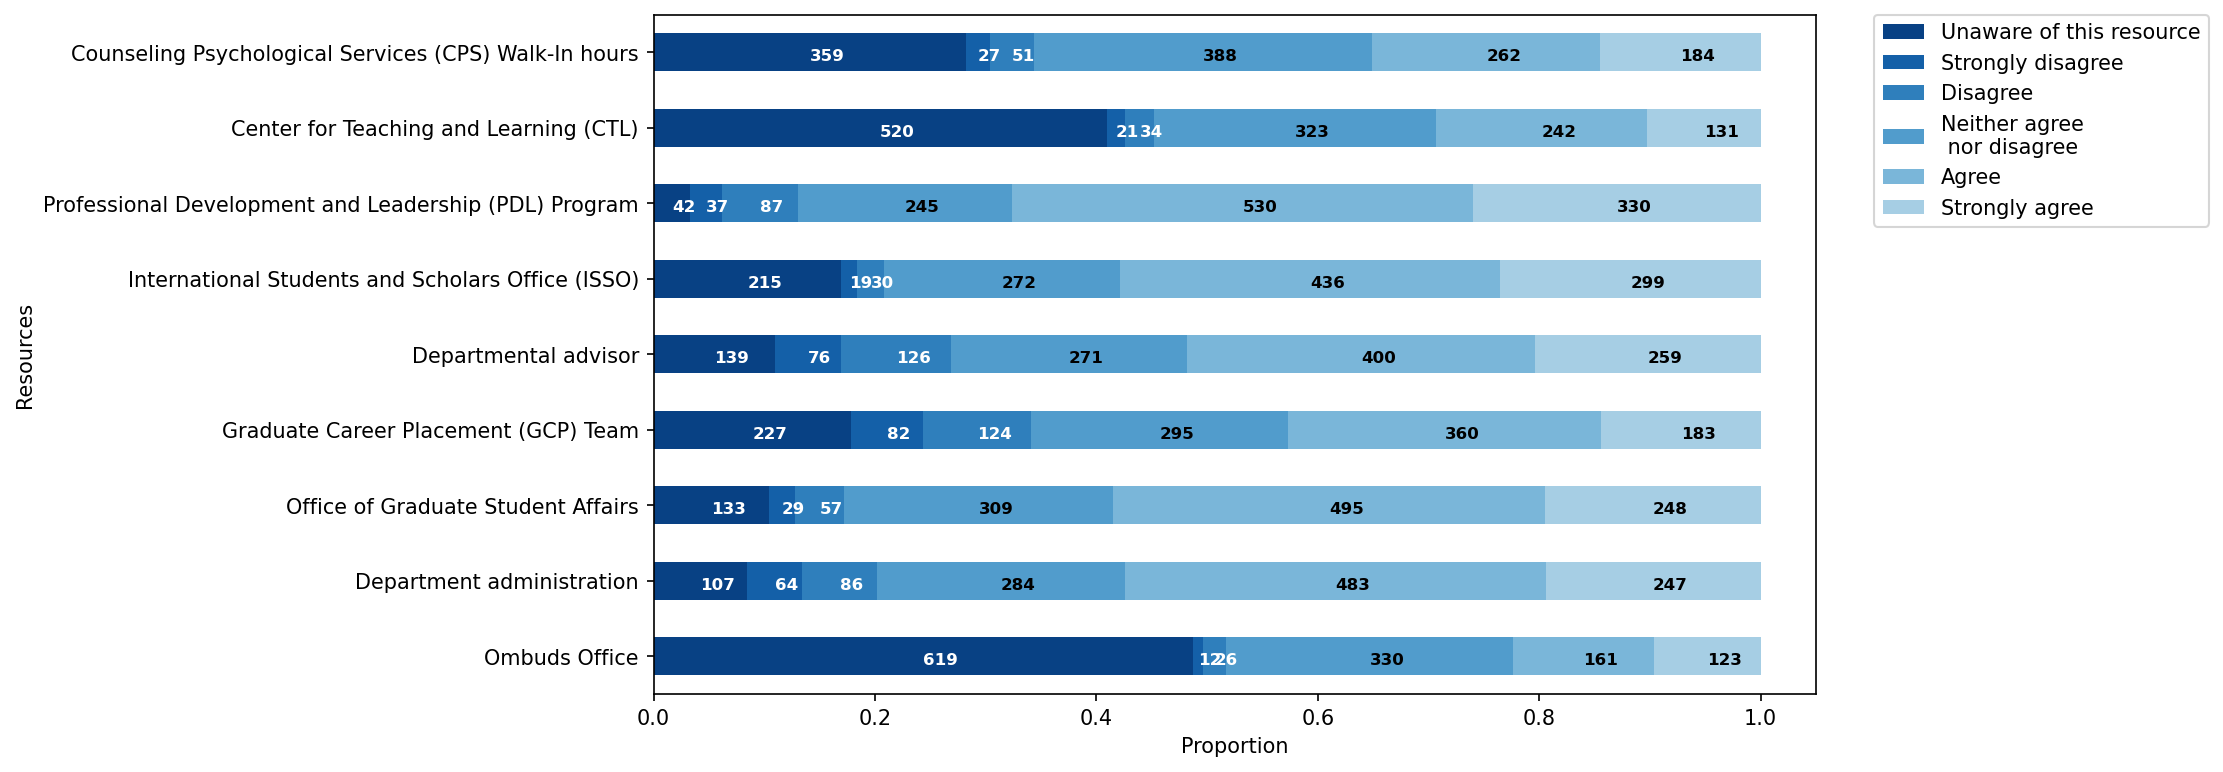

In [328]:
b_prob=resources_sat_count.apply(lambda x: x / x.sum(), axis=0)
aaa=resources_sat_count.T
bbb=b_prob.sort_index().T

cmap = mpl.cm.Blues_r(np.linspace(0,0.65,100))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])



fig,ax=plt.subplots(figsize=(8,6),dpi=150)
b_prob.sort_index().T.plot(kind='barh', stacked=True,colormap=cmap, figsize=(10, 6),label=b.T.columns,ax=ax)
#pd.DataFrame(b) 
plt.legend(inddd[::-1],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

#df3_1_cafe_count.index.name = 'rate'
#df3_1_cafe_count.columns.name = 'features'

plt.ylabel("Resources")
plt.xlabel("Proportion")
#plt.title("Overall Student Satisfaction: by Degree",fontsize=20)


for n, x in enumerate([*aaa.index.values]):
    m=5
    for (proportion, count, y_loc) in zip(bbb.loc[x],
                                          aaa.loc[x],
                                          bbb.loc[x].cumsum()):
        
        if m<3:
                 plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="black",
                 fontsize=8,
                 fontweight="bold")
        if m>=3:
                plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{str(count).split(".")[0]}', 
                 color="white",
                 fontsize=8,
                 fontweight="bold")
        m-=1

plt.show()

<BarContainer object of 9 artists>

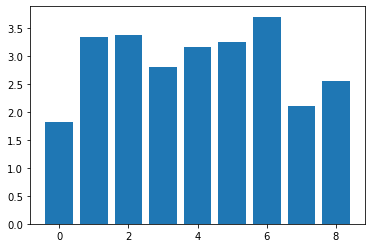

In [321]:
plt.bar(np.arange(len(resources_sat.mean(axis=0))),height=resources_sat.mean(axis=0))